# Laboratorium 3 - wieloręcy bandyci

## Przygotowanie

 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab3`
 * zainstaluj potrzebne biblioteki:
 `pip install matplotlib`
 * upewnij się, że plik `bandit_framework.py` najduje się w tym samym katalogu

## Część 1. - framework i naiwni bandyci

In [20]:
# importujemy wszystkie potrzebne pakiety

from copy import copy
from math import log, sqrt
from random import betavariate, normalvariate, random, sample, shuffle, uniform, choice
from bandit_framework import * # w tym pakiet ze srodowiskiem testowym

In [3]:
# inicjalizujemy parametry testu

arms_number = 50
runs = 50
epochs = 1440
recommendation_size = 10

In [4]:
# inicjalizujemy ramiona bandytow - payout kazdego ramienia bedzie reprezentowany przez rozklad normalny

arms = {}
for i in range(50):
    activation_probability = uniform(0.01, 0.7)
    mu = uniform(0.1, 2.5)
    sigma = min(uniform(0.1, 1), mu)
    arms['%s' % i] = Arm('%s' % i, activation_probability, lambda: normalvariate(mu, sigma))

arm_ids = list(arms.keys())

In [5]:
# pierwszy bandyta - wybiera losowe ramiona

class Random(Bandit):
    def __init__(self, bandit_id, arm_ids):
        super().__init__(bandit_id, arm_ids)
    
    def recommend(self, size):
        return choice(self.arm_ids)
    
    def feedback(self, arm_id, payout):
        pass

In [6]:
# ten bandyta oszukuje - zna mozliwosci kazdego z ramion i wybiera najelpsze - przyda nam sie do porownania

class Perfect(Bandit):
    def __init__(self, bandit_id, arm_ids, arms):
        super().__init__(bandit_id, arm_ids)
        self.arms = arms
        self.expected_payouts = {}
        for arm in arms.values():
            self.expected_payouts[arm.arm_id] = self.__find_expected_value(arm.payout_function) * arm.activation_probability
        self.arm_ids_sorted_by_expected_payout = [x[0] for x in sorted(self.expected_payouts.items(), key=lambda x: x[1], reverse=True)]

    def recommend(self, size):
        return self.arm_ids_sorted_by_expected_payout[:size]
    
    def feedback(self, arm_id, payout):
        pass
    
    def __find_expected_value(self, payout_function, n=100000):
        # brzydka, ale skuteczna sztuczka, zeby metoda brute-force znalexc wartosc oczekiwana
        return sum([payout_function() for i in range(n)]) / n

In [7]:
# tworzymy liste bandytow do przetestowania

bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]

In [8]:
# uruchamiamy test

runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect



Aggregated results:

perfect: 5562.596181696566
random: 373.4552263577797


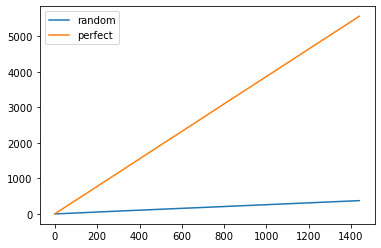

In [9]:
# wyniki sumaryczne dla wszystkich epok

runner.plot_results(results, runs, epochs, mode='cumulative')


Aggregated results:

perfect: 4.219776672824495
random: 0.2269129990014949


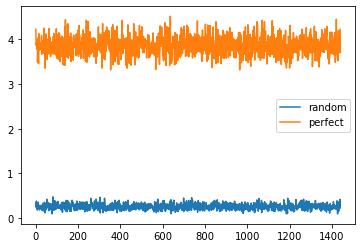

In [10]:
# wyniki per epoka

runner.plot_results(results, runs, epochs, mode='average')

## Część 2. - bandyci właściwi

In [11]:
class EGreedy(Bandit):
    def __init__(self, bandit_id, arm_ids, epsilon):
        super().__init__(bandit_id, arm_ids)
        self.epsilon = epsilon

        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
    
    def recommend(self, size):
        top_n = [x[0] for x in sorted(self.payouts_per_recommendation.items(), key=lambda x: x[1], reverse=True)][:size]
        randomized = copy(self.arm_ids)
        shuffle(randomized)
        
        recommendation = []
        
        # ...
        for i in range(size):
            if random() > self.epsilon:
                recommendation.append(top_n[i])
            else:
                recommendation.append(randomized[i])

        return recommendation
    
    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        # self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]
        self.payouts_per_recommendation[arm_id] =  self.payouts[arm_id] / self.recommended_rates[arm_id] if self.recommended_rates[arm_id] > 0 else self.payouts[arm_id]


In [21]:
class UCB(Bandit):
    def __init__(self, bandit_id, arm_ids, optimism_weight):
        super().__init__(bandit_id, arm_ids)
        self.optimism_weight = optimism_weight

        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
    
    def recommend(self, size):
        # ...
        recommendation = [x[0] for x in sorted(
            self.payouts_per_recommendation.items(), 
            key=lambda x: x[1] + self._optimism(x[0]),
            reverse=True
        )][:size]
        
        for arm in recommendation:
            self.recommended_rates[arm]+=1

        return recommendation
    
    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] =  self.payouts[arm_id] / self.recommended_rates[arm_id] if self.recommended_rates[arm_id] > 0 else self.payouts[arm_id]

    def _optimism(self, arm):
        n = self.recommended_rates[arm]
        n_sum = 0
        for x in self.recommended_rates.values():
            n_sum += x
        return sqrt(2 * log(n_sum)/n) if n > 0 else 0

In [13]:
class ThompsonSampling(Bandit):
    def __init__(self, bandit_id, arm_ids, reward_multiplier, regret_multiplier):
        super().__init__(bandit_id, arm_ids)
        self.reward_multiplier = reward_multiplier
        self.regret_multiplier = regret_multiplier
        self.a = {arm_id: 1 for arm_id in arm_ids}
        self.b = {arm_id: 1 for arm_id in arm_ids}
    
    def recommend(self, size):
        # ...
        beta = {arm_id: betavariate(self.a[arm_id], self.b[arm_id]) for arm_id in self.a.keys()}
        
        recommendation = [x[0] for x in sorted(
            beta.items(), 
            key=lambda x: x[1],
            reverse=True
        )][:size]

        return recommendation
    
    def feedback(self, arm_id, payout):
        reward = payout * self.reward_multiplier
        regret = max(1 - payout, 0) * self.regret_multiplier
        self.a[arm_id] += reward
        self.b[arm_id] += regret

## Część 3. - porównanie bandytów

In [22]:
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]
# nie wahaj sie wybrac innych wartosci parametrow bandytow
bandits.extend([EGreedy('egreedy_%s' % epsilon, arm_ids, epsilon) for epsilon in [0.01, 0.05, 0.1, 0.25]])
bandits.extend([UCB('ucb_%s' % optimism_weight, arm_ids, optimism_weight) for optimism_weight in [0.01, 0.1, 1, 10]])
bandits.extend([ThompsonSampling('ts_%s_%s' % (reward_weight, regret_weight), arm_ids, reward_weight, regret_weight)
                for reward_weight, regret_weight in [(1, 1), (10, 1), (1, 10), (10, 10)]])


In [23]:
runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect
Simulating: egreedy_0.01
Simulating: egreedy_0.05
Simulating: egreedy_0.1
Simulating: egreedy_0.25
Simulating: ucb_0.01
Simulating: ucb_0.1
Simulating: ucb_1
Simulating: ucb_10
Simulating: ts_1_1
Simulating: ts_10_1
Simulating: ts_1_10
Simulating: ts_10_10



Aggregated results:

perfect: 5556.658504533273
ts_1_10: 5544.078257171035
ts_1_1: 5541.182098065532
ts_10_1: 5522.856981912076
ts_10_10: 5391.9510797397525
egreedy_0.25: 4079.3902665813457
egreedy_0.1: 3875.768368638136
egreedy_0.01: 2576.488036059942
egreedy_0.05: 2303.8341645076584
ucb_0.1: 2040.8454450550696
ucb_10: 2037.2368605300062
ucb_0.01: 2036.8471197242916
ucb_1: 2033.9519777905912
random: 373.25635155034763


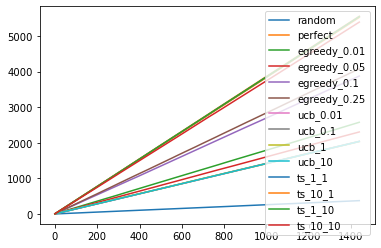

In [24]:
runner.plot_results(results, runs, epochs, mode='cumulative')